# Gesture Recognition

This project focuses on developing a 3D Convolutional Neural Network (CNN) designed to accurately recognize user hand gestures for controlling a smart TV. The primary goal is to create a hand gesture recognition model that can be integrated into a camera embedded within the smart TV, capable of interpreting five distinct gestures.

The system continuously monitors gestures via a webcam mounted on the TV, with each gesture mapped to a specific command:

Thumbs up: Increase the volume

Thumbs down: Decrease the volume

Left swipe: Skip backward 10 seconds

Right swipe: Skip forward 10 seconds

Stop: Pause the video

This approach enables intuitive and touch-free control of the smart TV through simple hand movements.

In [1]:
# Importing basic libraries 
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os

In [2]:
# Importing additional libraries for image pre-processing
import cv2  # OpenCV for image processing
from PIL import Image  # Python Imaging Library for image manipulation
import imageio as iio  # For reading and writing image data
from skimage import transform  # For image resizing and transformations

In [3]:
# Importing required modules from TensorFlow (Keras is now part of TensorFlow)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation, 
    Dropout, ZeroPadding3D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy

In [4]:
import random as rn
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)  # Updated for TensorFlow 2.x

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

In [5]:
# Check the Tensor flow version :

tf.__version__

'2.7.0'

In [33]:
# Uncomment if not using JarvisLabs
# # Ensure TensorFlow is using the GPU and allow memory growth to avoid resource exhaustion
# physical_devices = tf.config.list_physical_devices('GPU')
# if physical_devices:
#     for device in physical_devices:
#         tf.config.experimental.set_memory_growth(device, True)
#     print("GPU is available and memory growth is enabled.")
# else:
#     print("No GPU found. Using CPU.")

In this section, we will retrieve the folder names for both training and validation datasets. Additionally, we will define the batch_size here. It's important to set the batch size in a way that maximizes GPU utilization. To achieve this, we will incrementally increase the batch size until the system generates an error, ensuring optimal performance.

In [6]:
# Load and shuffle the training data
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())

# Load and shuffle the validation data
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

# Experiment with the batch size
batch_size = 25

In [7]:
# Custom function to crop image :
def crop_img(img, scale=1.0):
    # Get image dimensions
    height, width = img.shape[0], img.shape[1]

    # Calculate the center of the image
    center_x, center_y = width / 2, height / 2

    # Calculate the scaled width and height for the crop
    width_scaled, height_scaled = width * scale, height * scale

    # Ensure the crop dimensions do not exceed the image dimensions
    width_scaled = min(width_scaled, width)
    height_scaled = min(height_scaled, height)

    # Calculate the crop boundaries
    left_x = int(center_x - width_scaled / 2)
    right_x = int(center_x + width_scaled / 2)
    top_y = int(center_y - height_scaled / 2)
    bottom_y = int(center_y + height_scaled / 2)

    # Perform the crop
    img_cropped = img[top_y:bottom_y, left_x:right_x]

    return img_cropped

# Generator

This is one of the most critical components of the code. The overall structure of the generator has been provided. Within the generator, you will preprocess the images, especially since they come in two different dimensions, and assemble batches of video frames for processing. This step ensures the data is properly formatted and ready for training or validation.

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,64,64,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [9]:
curr_dt_time = datetime.datetime.now()

train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
num_epochs = 5
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


# Model Design

## First Base Model : Conv 3D Model with 5 epochs, 25 batch size

- ##### Without dropouts in Conv layer and with batch normalization
- ##### Input image size 64X64 , adam optimiser with learning rate 0.0002 with decay, 18 images as input out of 30

In [38]:
# Define the 3D CNN model
modelConv3D_1 = Sequential()

# First 3D Convolutional Layer
modelConv3D_1.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=(18, 64, 64, 3)))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second 3D Convolutional Layer
modelConv3D_1.add(Conv3D(16, (3, 3, 3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third 3D Convolutional Layer
modelConv3D_1.add(Conv3D(32, (3, 3, 3), padding='same'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fourth 3D Convolutional Layer
modelConv3D_1.add(Conv3D(64, (3, 3, 3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output for dense layers
modelConv3D_1.add(Flatten())

# First Dense Layer
modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

# Second Dense Layer
modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

# Output Layer
modelConv3D_1.add(Dense(5, activation='softmax'))

# Define the optimizer
optimiser = Adam(learning_rate=0.0002, decay=1e-6)

# Compile the model
modelConv3D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(modelConv3D_1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 64, 64, 8)     656       
                                                                 
 activation_4 (Activation)   (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_14 (Bat  (None, 18, 64, 64, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 32, 32, 8)     0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_5 (Activation)   (None, 9, 32, 32, 16)    

In [39]:
print("Total Params in model:", modelConv3D_1.count_params())


Total Params in model: 144421


Let us create the ```train_generator``` and the ```val_generator``` which will be used in .fit_generator.

In [40]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [41]:
# Create a directory for saving models
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
# Define the filepath for saving models
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Set up the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# Set up the ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Combine callbacks into a list
callbacks_list = [checkpoint, LR]

The ```steps_per_epoch``` and ```validation_steps``` are used by fit_generator to decide the number of next() calls it need to make.

In [42]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let’s now proceed to train the model. This will initiate the training process, and with the help of the checkpoints, the model will be saved at the end of every epoch for future use.

In [ ]:
# Training the 3D Conv model (modelConv3D_1)

history = modelConv3D_1.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Total number of epochs
    verbose=1,  # Verbosity mode (1 = progress bar)
    callbacks=callbacks_list,  # List of callbacks (e.g., ModelCheckpoint, ReduceLROnPlateau)
    validation_data=val_generator,  # Validation data generator
    class_weight=None,  # Optional class weights for imbalanced data
    initial_epoch=0  # Epoch to start training from
)

Source path =  /home/datasets/Project_data/train ; batch size = 25
Epoch 1/5
26/27 [===========================>..] - ETA: 0s - loss: 2.1472 - categorical_accuracy: 0.2477

In [ ]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Second Model : Conv 3D Model with 20 epochs, 30 batch size
Without dropouts in Conv layer and with batch normalization. Input image size 64X64 , adam optimiser with learning rate 0.0002 without decay, 18 images as input out of 30 Changed droput to 0.50 from 0.25 in 1st dense layer

In [16]:
batch_size = 30
num_epochs = 20

In [18]:
# Building the second model which is 3D Conv model:

# Define the 3D CNN model
modelConv3D_2 = Sequential()

# First 3D Convolutional Layer
modelConv3D_2.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

# Second 3D Convolutional Layer
modelConv3D_2.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

# Third 3D Convolutional Layer
modelConv3D_2.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth 3D Convolutional Layer
modelConv3D_2.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten the output for dense layers
modelConv3D_2.add(Flatten())

# First Dense Layer
modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.50))

# Second Dense Layer
modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.25))

# Output Layer
modelConv3D_2.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = Adam(learning_rate=0.0002)

# compile model :
modelConv3D_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 64, 64, 8)     656       
                                                                 
 activation_8 (Activation)   (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_12 (Bat  (None, 18, 64, 64, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 32, 32, 8)     0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_9 (Activation)   (None, 9, 32, 32, 16)    

In [19]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


In [20]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'modelConv3D_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
# Training the 3D Conv model (modelConv3D_2)

history = modelConv3D_2.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Total number of epochs
    verbose=1,  # Verbosity mode (1 = progress bar)
    callbacks=callbacks_list,  # List of callbacks (e.g., ModelCheckpoint, ReduceLROnPlateau)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Number of validation steps
    class_weight=None,  # Optional class weights for imbalanced data
    initial_epoch=0  # Epoch to start training from
)

Source path = /home/datasets/Project_data/train; Batch size = 30
Epoch 1/20


2025-01-28 12:53:35.788400: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 2.2200 - categorical_accuracy: 0.2187Source path = /home/datasets/Project_data/val; Batch size = 30

Epoch 00001: saving model to modelConv3D_2_2025-01-2812_52_59.480290/model-00001-2.22005-0.21870-1.61494-0.15000.keras
23/23 [==============================] - 26s 1s/step - loss: 2.2200 - categorical_accuracy: 0.2187 - val_loss: 1.6149 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.9164 - categorical_accuracy: 0.3002
Epoch 00002: saving model to modelConv3D_2_2025-01-2812_52_59.480290/model-00002-1.91643-0.30015-1.64843-0.16000.keras
23/23 [==============================] - 22s 1s/step - loss: 1.9164 - categorical_accuracy: 0.3002 - val_loss: 1.6484 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.6822 - categorical_accuracy: 0.3665
Epoch 00003: saving model to modelConv3D_2_2025-01-2

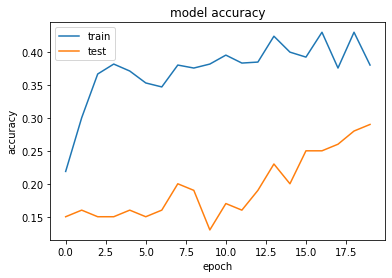

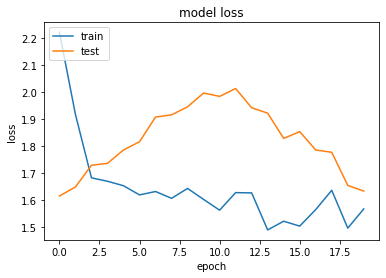

In [23]:
# Plotting the result of Model 2 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Third Model : Conv 3D Model with 20 epochs and 30 batch size , image size increaed to 84X84, reduced cropping to 3 % from 10 %m

The model excludes dropouts in convolutional layers but includes batch normalization. It uses the Adam optimizer with a fixed learning rate of 0.0002 (no decay). Input consists of 18 images out of 30. Dropout in the first dense layer was reverted from 0.50 to 0.25. These adjustments aim to balance feature extraction and overfitting while maintaining model performance. Training logs indicate progress in accuracy and loss metrics.

In [24]:
def generator_modified(source_path, folder_list, batch_size):
    print(f'Source path = {source_path}; batch size = {batch_size}')
    img_idx = [1, 2, 4, 6, 7, 8, 10, 12, 14, 16, 18, 20, 21, 22, 24, 26, 27, 29]  # Selected frames

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, 18, 84, 84, 3))  # Initialize batch data
            batch_labels = np.zeros((batch_size, 5))  # Initialize batch labels

            for folder in range(batch_size):
                folder_path = source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(folder_path))  # List images in folder

                for idx, item in enumerate(img_idx):
                    image = cv2.imread(folder_path + '/' + imgs[item], cv2.IMREAD_UNCHANGED).astype(np.float32)
                    image = crop_img(image, 0.03)  # Crop image by 3%
                    image = cv2.resize(image[:, 20:140, :] if image.shape[1] == 160 else image, (84, 84), interpolation=cv2.INTER_AREA)  # Resize
                    batch_data[folder, idx] = image / 255  # Normalize and store

                label = int(t[folder + (batch * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1  # One-hot encode label

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(t) % batch_size != 0:
            remaining = len(t) % batch_size
            batch_data = np.zeros((remaining, 18, 84, 84, 3))
            batch_labels = np.zeros((remaining, 5))

            for folder in range(remaining):
                folder_path = source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(folder_path))

                for idx, item in enumerate(img_idx):
                    image = cv2.imread(folder_path + '/' + imgs[item], cv2.IMREAD_UNCHANGED).astype(np.float32)
                    image = crop_img(image, 0.03)
                    image = cv2.resize(image[:, 20:140, :] if image.shape[1] == 160 else image, (84, 84), interpolation=cv2.INTER_AREA)
                    batch_data[folder, idx] = image / 255

                label = int(t[folder + (num_batches * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels

In [25]:
curr_dt_time = datetime.datetime.now()

train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

batch_size = 30
print ('# batch_size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 30


In [26]:
# Building the  model which is 3D Conv model:

# Define the 3D CNN model
modelConv3D_3 = Sequential()

# First 3D Convolutional Layer
modelConv3D_3.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,84,84,3)))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

# Second 3D Convolutional Layer
modelConv3D_3.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

# Third 3D Convolutional Layer
modelConv3D_3.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth 3D Convolutional Layer
modelConv3D_3.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten the output for dense layers
modelConv3D_3.add(Flatten())

# First Dense Layer
modelConv3D_3.add(Dense(128, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

# Second Dense Layer
modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

# Output Layer
modelConv3D_3.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = Adam(learning_rate=0.0002)

# compile model :
modelConv3D_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 84, 84, 8)     656       
                                                                 
 activation_12 (Activation)  (None, 18, 84, 84, 8)     0         
                                                                 
 batch_normalization_18 (Bat  (None, 18, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 42, 42, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 42, 42, 16)     3472      
                                                                 
 activation_13 (Activation)  (None, 9, 42, 42, 16)    

In [27]:
print("Total Params in model:", modelConv3D_3.count_params())

Total Params in model: 288101


In [28]:
train_generator = generator_modified(train_path, train_doc, batch_size)
val_generator = generator_modified(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [29]:
# Training the 3D Conv model (modelConv3D_3)

history = modelConv3D_3.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Total number of epochs
    verbose=1,  # Verbosity mode (1 = progress bar)
    callbacks=callbacks_list,  # List of callbacks (e.g., ModelCheckpoint, ReduceLROnPlateau)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Number of validation steps
    class_weight=None,  # Optional class weights for imbalanced data
    initial_epoch=0  # Epoch to start training from
)

Source path = /home/datasets/Project_data/train; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.2004 - categorical_accuracy: 0.2308Source path = /home/datasets/Project_data/val; batch size = 30

Epoch 00001: saving model to model_init_2025-01-2813_01_28.217419/model-00001-2.20040-0.23077-1.62388-0.21000.keras
23/23 [==============================] - 26s 1s/step - loss: 2.2004 - categorical_accuracy: 0.2308 - val_loss: 1.6239 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.7132 - categorical_accuracy: 0.3906
Epoch 00002: saving model to model_init_2025-01-2813_01_28.217419/model-00002-1.71317-0.39065-1.62087-0.22000.keras
23/23 [==============================] - 24s 1s/step - loss: 1.7132 - categorical_accuracy: 0.3906 - val_loss: 1.6209 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.7203 - categorical

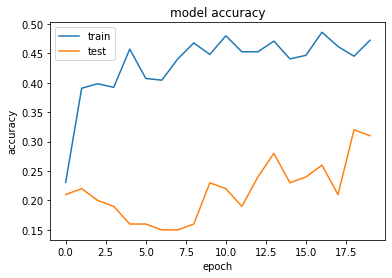

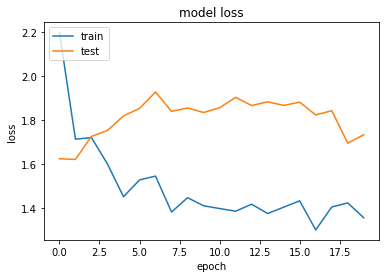

In [30]:
# Plotting the result of Model 3 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Fourth Model : Conv 3D model
##### Increase the image size to 100x100, batch size 50, epoch 30

In [31]:
def generator(source_path, folder_list, batch_size):
    print(f'Source path = {source_path}; batch size = {batch_size}')
    img_idx = [1, 2, 4, 6, 7, 8, 10, 12, 14, 16, 18, 20, 21, 22, 24, 26, 27, 29]  # Selected frames

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, 18, 100, 100, 3))  # Initialize batch data
            batch_labels = np.zeros((batch_size, 5))  # Initialize batch labels

            for folder in range(batch_size):
                folder_path = source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(folder_path))  # List images in folder

                for idx, item in enumerate(img_idx):
                    image = cv2.imread(folder_path + '/' + imgs[item], cv2.IMREAD_UNCHANGED).astype(np.float32)
                    image = crop_img(image, 0.02)  # Crop image by 2%
                    image = cv2.resize(image[:, 20:140, :] if image.shape[1] == 160 else image, (100, 100), interpolation=cv2.INTER_AREA)  # Resize
                    batch_data[folder, idx] = image / 255  # Normalize and store

                label = int(t[folder + (batch * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1  # One-hot encode label

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(t) % batch_size != 0:
            remaining = len(t) % batch_size
            batch_data = np.zeros((remaining, 18, 100, 100, 3))
            batch_labels = np.zeros((remaining, 5))

            for folder in range(remaining):
                folder_path = source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(folder_path))

                for idx, item in enumerate(img_idx):
                    image = cv2.imread(folder_path + '/' + imgs[item], cv2.IMREAD_UNCHANGED).astype(np.float32)
                    image = crop_img(image, 0.02)
                    image = cv2.resize(image[:, 20:140, :] if image.shape[1] == 160 else image, (100, 100), interpolation=cv2.INTER_AREA)
                    batch_data[folder, idx] = image / 255

                label = int(t[folder + (num_batches * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels

In [32]:
modelConv3D_4 = Sequential()

# First 3D Convolutional Layer
modelConv3D_4.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(18,100,100,3), padding='same'))
modelConv3D_4.add(BatchNormalization())  # Normalize activations
modelConv3D_4.add(Activation('relu'))   # Apply ReLU activation
modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))  # Downsample feature maps

# Second 3D Convolutional Layer
modelConv3D_4.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

# Third 3D Convolutional Layer
modelConv3D_4.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth 3D Convolutional Layer
modelConv3D_4.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(Dropout(0.25))  # Regularization to prevent overfitting
modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten the 3D feature maps into a 1D vector
modelConv3D_4.add(Flatten())

# Fully Connected Layers
modelConv3D_4.add(Dense(256, activation='relu'))  # Dense layer with ReLU
modelConv3D_4.add(Dropout(0.25))  # Regularization
modelConv3D_4.add(Dense(128, activation='relu'))  # Another dense layer
modelConv3D_4.add(Dropout(0.25))  # Regularization

# Output Layer with Softmax Activation for Multi-Class Classification
modelConv3D_4.add(Dense(5, activation='softmax'))

In [33]:
optimiser = Adam() #write your optimizer
modelConv3D_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_4.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 18, 100, 100, 8)   656       
                                                                 
 batch_normalization_24 (Bat  (None, 18, 100, 100, 8)  32        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 18, 100, 100, 8)   0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 9, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 9, 50, 50, 16)     3472      
                                                                 
 batch_normalization_25 (Bat  (None, 9, 50, 50, 16)   

In [34]:
print("Total Params in model:", modelConv3D_4.count_params())

Total Params in model: 651109


In [35]:
curr_dt_time = datetime.datetime.now()

train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

batch_size = 50
num_epochs = 30

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# training sequences = 663
# validation sequences = 100


In [36]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
# Training the 3D Conv model (modelConv3D_4)

history = modelConv3D_4.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Total number of epochs
    verbose=1,  # Verbosity mode (1 = progress bar)
    callbacks=callbacks_list,  # List of callbacks (e.g., ModelCheckpoint, ReduceLROnPlateau)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Number of validation steps
    class_weight=None,  # Optional class weights for imbalanced data
    initial_epoch=0  # Epoch to start training from
)

Source path = /home/datasets/Project_data/train; batch size = 50
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.9143 - categorical_accuracy: 0.2504Source path = /home/datasets/Project_data/val; batch size = 50

Epoch 00001: saving model to model_init_2025-01-2813_09_36.814373/model-00001-1.91426-0.25038-1.60080-0.25000.keras
14/14 [==============================] - 27s 2s/step - loss: 1.9143 - categorical_accuracy: 0.2504 - val_loss: 1.6008 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.5134 - categorical_accuracy: 0.3424
Epoch 00002: saving model to model_init_2025-01-2813_09_36.814373/model-00002-1.51344-0.34238-1.60800-0.18000.keras
14/14 [==============================] - 26s 2s/step - loss: 1.5134 - categorical_accuracy: 0.3424 - val_loss: 1.6080 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 1.4571 - categorical_accurac

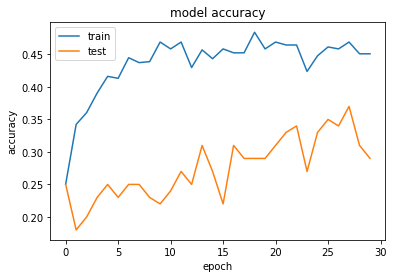

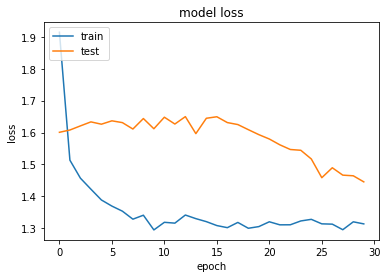

In [39]:
# Plotting the result of Model 4 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model 5 : Conv 3D model
##### batch size 30, increased image inputs to 30 , image size recuced to 84

In [40]:
batch_size = 30

In [41]:
def generator(source_path, folder_list, batch_size):
    print(f'Source path = {source_path}; batch size = {batch_size}')
    
    # List of image indices to use for each video (all 30 frames)
    img_idx = [x for x in range(0, 30)]
    
    while True:
        t = np.random.permutation(folder_list)  # Shuffle folder list
        num_batches = len(t) // batch_size  # Calculate number of full batches

        # Iterate over full batches
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size, 30, 84, 84, 3))  # Initialize batch data (30 frames, 84x84 resolution, 3 channels)
            batch_labels = np.zeros((batch_size, 5))  # Initialize batch labels (one-hot encoded)

            # Process each folder in the batch
            for folder in range(batch_size): 
                folder_path = source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(folder_path))  # List and sort images in the folder

                # Read and preprocess each frame
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(folder_path + '/' + imgs[item], cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Resize images to 84x84 (handle two different input shapes)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:, 20:140, :], (84, 84), interpolation=cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image, (84, 84), interpolation=cv2.INTER_AREA).astype(np.float32)
                    
                    # Normalize and store the image
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                # One-hot encode the label
                label = int(t[folder + (batch * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels  # Yield the batch

        # Handle remaining data points (incomplete batch)
        if len(t) % batch_size != 0:
            remaining = len(t) % batch_size
            batch_data = np.zeros((remaining, 30, 84, 84, 3))
            batch_labels = np.zeros((remaining, 5))

            for folder in range(remaining):
                folder_path = source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(folder_path))

                for idx, item in enumerate(img_idx):
                    image = cv2.imread(folder_path + '/' + imgs[item], cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:, 20:140, :], (84, 84), interpolation=cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image, (84, 84), interpolation=cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                label = int(t[folder + (num_batches * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels  # Yield the remaining batch

In [42]:
modelConv3D_5 = Sequential()

# First 3D Convolutional Layer
modelConv3D_5.add(Conv3D(8, (3,3,3), padding='same', input_shape=(30,84,84,3)))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

# Second 3D Convolutional Layer
modelConv3D_5.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

# Third 3D Convolutional Layer
modelConv3D_5.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth 3D Convolutional Layer
modelConv3D_5.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten the output for dense layers
modelConv3D_5.add(Flatten())

# First Dense Layer
modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

# Second Dense Layer
modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

# Output Layer
modelConv3D_5.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = Adam(learning_rate=0.0002)

# compile model :
modelConv3D_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_5.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 84, 84, 8)     656       
                                                                 
 activation_20 (Activation)  (None, 30, 84, 84, 8)     0         
                                                                 
 batch_normalization_27 (Bat  (None, 30, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 42, 42, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 42, 42, 16)    3472      
                                                                 
 activation_21 (Activation)  (None, 15, 42, 42, 16)   

In [43]:
print("Total Params in model:", modelConv3D_5.count_params())

Total Params in model: 181285


In [44]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

In [45]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [46]:
# Training the 3D Conv model (modelConv3D_5)

history = modelConv3D_5.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Total number of epochs
    verbose=1,  # Verbosity mode (1 = progress bar)
    callbacks=callbacks_list,  # List of callbacks (e.g., ModelCheckpoint, ReduceLROnPlateau)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Number of validation steps
    class_weight=None,  # Optional class weights for imbalanced data
    initial_epoch=0  # Epoch to start training from
)

Source path = /home/datasets/Project_data/train; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.0908 - categorical_accuracy: 0.2534Source path = /home/datasets/Project_data/val; batch size = 30

Epoch 00001: saving model to model_init_2025-01-2813_09_36.814373/model-00001-2.09082-0.25339-1.60704-0.22000.keras
23/23 [==============================] - 51s 2s/step - loss: 2.0908 - categorical_accuracy: 0.2534 - val_loss: 1.6070 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5443 - categorical_accuracy: 0.4163
Epoch 00002: saving model to model_init_2025-01-2813_09_36.814373/model-00002-1.54433-0.41629-1.70588-0.13000.keras
23/23 [==============================] - 47s 2s/step - loss: 1.5443 - categorical_accuracy: 0.4163 - val_loss: 1.7059 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.3142 - categorical

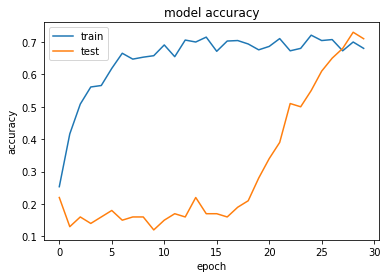

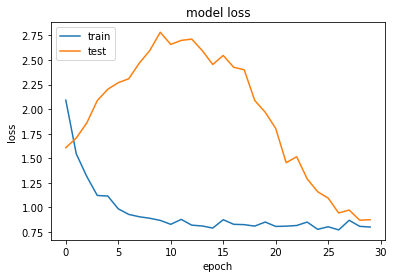

In [47]:
# Plotting the result of Model 5 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model 6 : CNN - LSTM Model

In [48]:
# Input
input_shape=(30,120,120,3)

In [49]:
CNNlstm_1 = Sequential()

# TimeDistributed wrapper allows applying Conv2D to each frame in the sequence independently
CNNlstm_1.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))  # Normalize activations
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))  # Downsample feature maps

# Second Conv2D layer
CNNlstm_1.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# Third Conv2D layer
CNNlstm_1.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# Fourth Conv2D layer
CNNlstm_1.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# Fifth Conv2D layer
CNNlstm_1.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten the output of Conv2D layers for each frame
CNNlstm_1.add(TimeDistributed(Flatten()))

# LSTM layer to capture temporal dependencies
CNNlstm_1.add(LSTM(128))  # 128 LSTM units
CNNlstm_1.add(Dropout(0.25))  # Regularization to prevent overfitting

# Fully Connected Layer
CNNlstm_1.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
CNNlstm_1.add(Dropout(0.25))  # Regularization

# Output Layer with Softmax Activation for Multi-Class Classification
CNNlstm_1.add(Dense(5, activation='softmax'))

# Define optimizer (Adam with default parameters)
optimiser = Adam()

# Compile the model
CNNlstm_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print model summary
print(CNNlstm_1.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)  

In [50]:
batch_size = 20

curr_dt_time = datetime.datetime.now()

train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [14]:
def generatorLSTM(source_path, folder_list, batch_size):
    print(f'Source path = {source_path}; batch size = {batch_size}')
    
    # List of image indices to use for each video (all 30 frames)
    img_idx = [x for x in range(0, 30)]
    
    while True:
        t = np.random.permutation(folder_list)  # Shuffle folder list
        num_batches = len(t) // batch_size  # Calculate number of full batches

        # Iterate over full batches
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size, 30, 120, 120, 3))  # Initialize batch data (30 frames, 120x120 resolution, 3 channels)
            batch_labels = np.zeros((batch_size, 5))  # Initialize batch labels (one-hot encoded)

            # Process each folder in the batch
            for folder in range(batch_size): 
                folder_path = source_path + '/' + t[folder + (batch * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(folder_path))  # List and sort images in the folder

                # Read and preprocess each frame
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(folder_path + '/' + imgs[item], cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Resize images to 120x120 (handle two different input shapes)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:, 20:140, :], (120, 120), interpolation=cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image, (120, 120), interpolation=cv2.INTER_AREA).astype(np.float32)
                    
                    # Normalize and store the image
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                # One-hot encode the label
                label = int(t[folder + (batch * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels  # Yield the batch

        # Handle remaining data points (incomplete batch)
        if len(t) % batch_size != 0:
            remaining = len(t) % batch_size
            batch_data = np.zeros((remaining, 30, 120, 120, 3))
            batch_labels = np.zeros((remaining, 5))

            for folder in range(remaining):
                folder_path = source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0]
                imgs = sorted(os.listdir(folder_path))

                for idx, item in enumerate(img_idx):
                    image = cv2.imread(folder_path + '/' + imgs[item], cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:, 20:140, :], (120, 120), interpolation=cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image, (120, 120), interpolation=cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                label = int(t[folder + (num_batches * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels  # Yield the remaining batch

In [52]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [53]:
# Training the CNN lStm (CNNlstm_1)

history = CNNlstm_1.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Total number of epochs
    verbose=1,  # Verbosity mode (1 = progress bar)
    callbacks=callbacks_list,  # List of callbacks (e.g., ModelCheckpoint, ReduceLROnPlateau)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Number of validation steps
    class_weight=None,  # Optional class weights for imbalanced data
    initial_epoch=0  # Epoch to start training from
)

Source path = /home/datasets/Project_data/train; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3969 - categorical_accuracy: 0.4148Source path = /home/datasets/Project_data/val; batch size = 20

Epoch 00001: saving model to model_init_2025-01-2813_46_03.244521/model-00001-1.39691-0.41478-1.67899-0.16000.keras
34/34 [==============================] - 86s 2s/step - loss: 1.3969 - categorical_accuracy: 0.4148 - val_loss: 1.6790 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0040 - categorical_accuracy: 0.6290
Epoch 00002: saving model to model_init_2025-01-2813_46_03.244521/model-00002-1.00403-0.62896-1.71645-0.14000.keras
34/34 [==============================] - 75s 2s/step - loss: 1.0040 - categorical_accuracy: 0.6290 - val_loss: 1.7164 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/20
33/34 [============================>.] - ETA: 1s - loss: 0.7923 - categorical_accurac

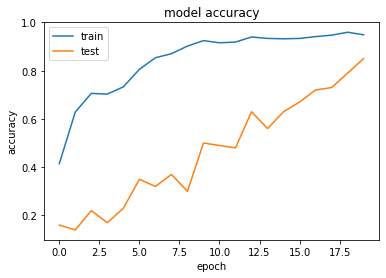

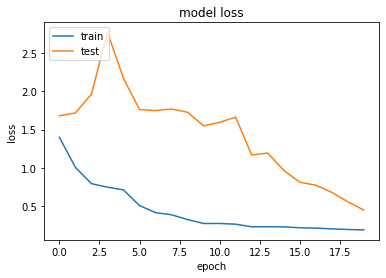

In [54]:
# Plotting the result of Model 6 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model 7 : CNN - LSTM Model , increase input image size to 160x160

In [72]:
# Input
input_shape=(30,160,160,3)

In [73]:
CNNlstm_2 = Sequential()

CNNlstm_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Flatten()))


CNNlstm_2.add(LSTM(128))
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(128,activation='relu'))
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(5, activation='softmax'))


#write your optimizer
optimiser = Adam()

# compile model :
CNNlstm_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_2.summary())


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_80 (TimeDi  (None, 30, 160, 160, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 30, 160, 160, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 30, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 30, 80, 80, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 30, 80, 80, 32) 

In [74]:
print("Total Params in model:", CNNlstm_2.count_params())

Total Params in model: 3754597


In [75]:
def generatorLSTM1(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,160,160,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,160,160,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [76]:
train_generator = generatorLSTM1(train_path, train_doc, batch_size)
val_generator = generatorLSTM1(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [77]:
# Training the CNN LSTM (CNNlstm_2)

history = CNNlstm_2.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Total number of epochs
    verbose=1,  # Verbosity mode (1 = progress bar)
    callbacks=callbacks_list,  # List of callbacks (e.g., ModelCheckpoint, ReduceLROnPlateau)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Number of validation steps
    class_weight=None,  # Optional class weights for imbalanced data
    initial_epoch=0  # Epoch to start training from
)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4550 - categorical_accuracy: 0.3725Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2025-01-2813_46_03.244521/model-00001-1.45498-0.37255-1.80170-0.22000.keras
34/34 [==============================] - 155s 5s/step - loss: 1.4550 - categorical_accuracy: 0.3725 - val_loss: 1.8017 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2228 - categorical_accuracy: 0.4646
Epoch 00002: saving model to model_init_2025-01-2813_46_03.244521/model-00002-1.22275-0.46456-1.71487-0.17000.keras
34/34 [==============================] - 126s 4s/step - loss: 1.2228 - categorical_accuracy: 0.4646 - val_loss: 1.7149 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1951 - categorical_a

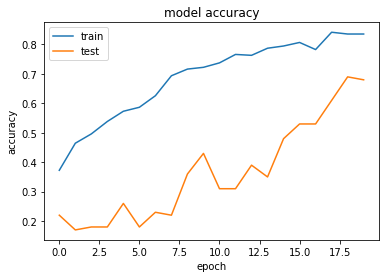

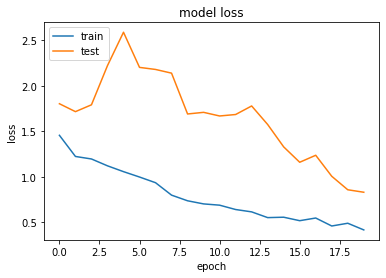

In [78]:
# Plotting the result of Model 7 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model 8 : CNN - LSTM Model , Increase layers , increase epoch to 25

In [80]:

input_shape=(30,120,120,3)

CNNlstm_3 = Sequential()
CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_3.add(Flatten())
CNNlstm_3.add(Dense(64,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))

CNNlstm_3.add(Dense(64,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))


CNNlstm_3.add(Dense(5,activation='softmax'))

optimiser = Adam()
CNNlstm_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_3.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_73 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_33 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_33 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_74 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                    

In [81]:
print("Total Params in model:", CNNlstm_3.count_params())

Total Params in model: 1287989


In [82]:
batch_size = 20

curr_dt_time = datetime.datetime.now()

train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [83]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [84]:
# Training the CNN LSTM(CNNlstm_3)

history = CNNlstm_3.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Total number of epochs
    verbose=1,  # Verbosity mode (1 = progress bar)
    callbacks=callbacks_list,  # List of callbacks (e.g., ModelCheckpoint, ReduceLROnPlateau)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Number of validation steps
    class_weight=None,  # Optional class weights for imbalanced data
    initial_epoch=0  # Epoch to start training from
)

Source path = /home/datasets/Project_data/train; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6564 - categorical_accuracy: 0.4027Source path = /home/datasets/Project_data/val; batch size = 20

Epoch 00001: saving model to model_init_2025-01-2815_11_34.337825/model-00001-1.65644-0.40271-2.23289-0.22000.keras
34/34 [==============================] - 77s 2s/step - loss: 1.6564 - categorical_accuracy: 0.4027 - val_loss: 2.2329 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3278 - categorical_accuracy: 0.4887
Epoch 00002: saving model to model_init_2025-01-2815_11_34.337825/model-00002-1.32775-0.48869-2.05835-0.19000.keras
34/34 [==============================] - 90s 3s/step - loss: 1.3278 - categorical_accuracy: 0.4887 - val_loss: 2.0583 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0890 - categorical_accurac

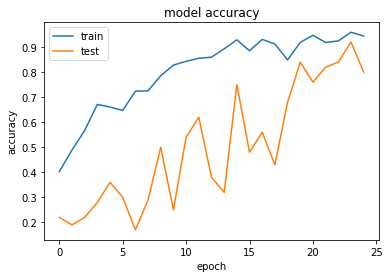

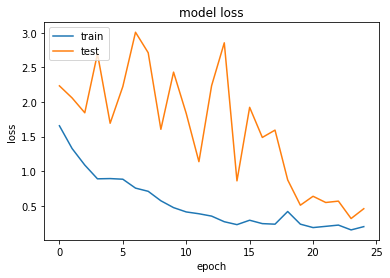

In [85]:
# Plotting the result of Model 8 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model 9 : CNN - LSTM Model, Increase network paramaters

In [10]:
input_shape=(30,120,120,3)

CNNlstm_4 = Sequential()
CNNlstm_4.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_4.add(Flatten())
CNNlstm_4.add(Dense(128,activation='relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(Dropout(0.25))

CNNlstm_4.add(Dense(128,activation='relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(Dropout(0.25))


CNNlstm_4.add(Dense(5,activation='softmax'))

optimiser = Adam()
CNNlstm_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (CNNlstm_4.summary())

2025-01-29 02:33:57.217645: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-29 02:33:57.217707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                        

In [11]:
print("Total Params in model:", CNNlstm_4.count_params())

Total Params in model: 1702645


In [12]:
batch_size = 20

curr_dt_time = datetime.datetime.now()

train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [15]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
# Training the lstm (CNNlstm_4)

history = CNNlstm_4.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Total number of epochs
    verbose=1,  # Verbosity mode (1 = progress bar)
    callbacks=callbacks_list,  # List of callbacks (e.g., ModelCheckpoint, ReduceLROnPlateau)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Number of validation steps
    class_weight=None,  # Optional class weights for imbalanced data
    initial_epoch=0  # Epoch to start training from
)

Source path = /home/datasets/Project_data/train; batch size = 20
Epoch 1/25


2025-01-29 02:34:40.878458: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.5081 - categorical_accuracy: 0.4238Source path = /home/datasets/Project_data/val; batch size = 20

Epoch 00001: saving model to model_init_2025-01-2902_34_05.886628/model-00001-1.50813-0.42383-3.04304-0.21000.keras
34/34 [==============================] - 68s 2s/step - loss: 1.5081 - categorical_accuracy: 0.4238 - val_loss: 3.0430 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.8423 - categorical_accuracy: 0.6682
Epoch 00002: saving model to model_init_2025-01-2902_34_05.886628/model-00002-0.84234-0.66817-3.33076-0.21000.keras
34/34 [==============================] - 47s 1s/step - loss: 0.8423 - categorical_accuracy: 0.6682 - val_loss: 3.3308 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.7027 - categorical_accuracy: 0.7421
Epoch 00003: saving model to model_init_2025-01-2902_34_05.886628/

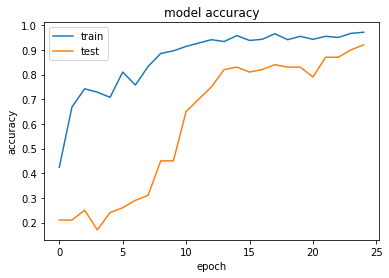

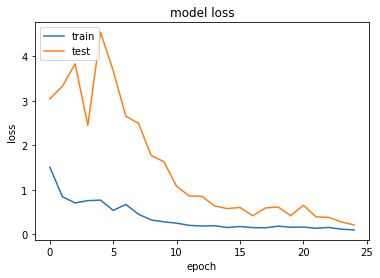

In [ ]:
# Plotting the result of Model 9 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model 10 : CNN LSTM with GRU

In [10]:
input_shape=(30,120,120,3)

GRU_lstm = Sequential()

GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_shape)))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))


GRU_lstm.add(TimeDistributed(Flatten()))


GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(128,activation='relu'))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(5, activation='softmax'))
optimiser = Adam()
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (GRU_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 60, 60, 32)  

In [11]:
print("Total Params in model:", GRU_lstm.count_params())

Total Params in model: 2573925


In [12]:
batch_size = 20
curr_dt_time = datetime.datetime.now()

train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [16]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [17]:
# Training the GRU LSTM  (GRU_lstm)

history = GRU_lstm.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    epochs=num_epochs,  # Total number of epochs
    verbose=1,  # Verbosity mode (1 = progress bar)
    callbacks=callbacks_list,  # List of callbacks (e.g., ModelCheckpoint, ReduceLROnPlateau)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Number of validation steps
    class_weight=None,  # Optional class weights for imbalanced data
    initial_epoch=0  # Epoch to start training from
)

Source path = /home/datasets/Project_data/train; batch size = 20
Epoch 1/20


2025-01-28 16:34:05.568500: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.4699 - categorical_accuracy: 0.3876Source path = /home/datasets/Project_data/val; batch size = 20

Epoch 00001: saving model to model_init_2025-01-2816_33_05.875818/model-00001-1.46991-0.38763-1.68200-0.28000.keras
34/34 [==============================] - 56s 2s/step - loss: 1.4699 - categorical_accuracy: 0.3876 - val_loss: 1.6820 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0658 - categorical_accuracy: 0.5837
Epoch 00002: saving model to model_init_2025-01-2816_33_05.875818/model-00002-1.06581-0.58371-1.69457-0.22000.keras
34/34 [==============================] - 52s 2s/step - loss: 1.0658 - categorical_accuracy: 0.5837 - val_loss: 1.6946 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9332 - categorical_accuracy: 0.6259
Epoch 00003: saving model to model_init_2025-01-2816_33_05.875818/

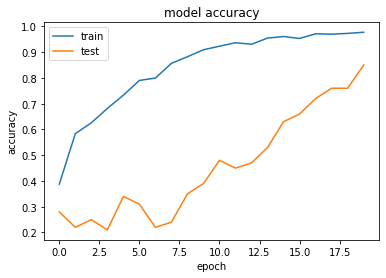

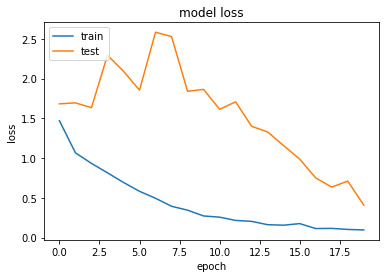

In [ ]:
# Plotting the result of Model 10 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()